<a href="https://colab.research.google.com/github/mayaparvathy/mayaparvathy/blob/main/LSTM_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving lstm.csv to lstm (4).csv


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-1896480656.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t]) # Add actual observation for next prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


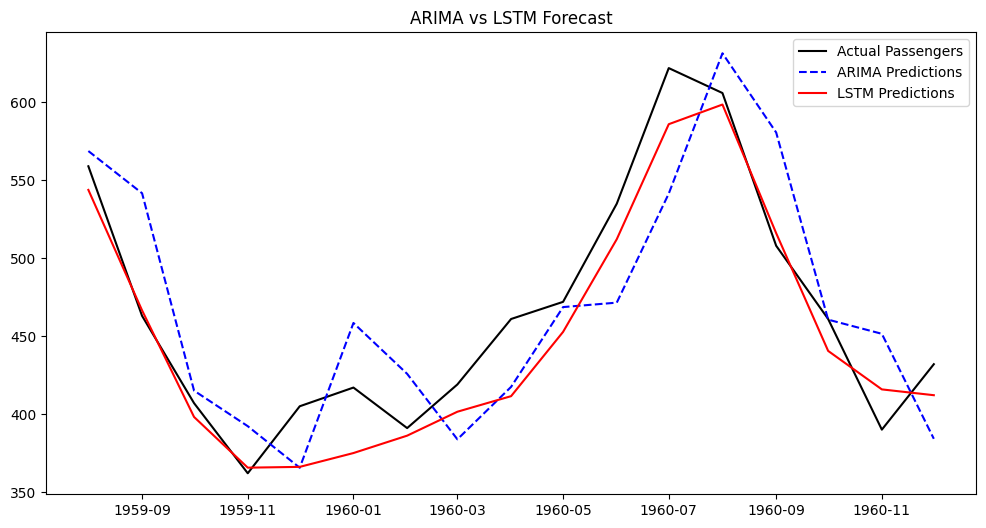

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# 1. Load and Preprocess
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('/content/lstm (2).csv') # Corrected filename
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data.set_index('Month', inplace=True)
series = data['#Passengers'] # Corrected column name

# 2. Split Data
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# --- PART A: LSTM PREPARATION ---
# LSTMs are sensitive to scale; we must normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Create sequences (Windowing)
def create_dataset(dataset, look_back=12):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

# Reshape to [samples, time steps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# --- PART B: MODEL TRAINING ---

# 1. LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

# 2. ARIMA Model (Walk-forward validation)
history = [x for x in train]
arima_preds = []
for t in range(len(test)):
    model_arima = ARIMA(history, order=(5,1,0))
    model_fit = model_arima.fit()
    yhat = model_fit.forecast()[0]
    arima_preds.append(yhat)
    history.append(test[t]) # Add actual observation for next prediction

# --- PART C: PREDICTIONS & EVALUATION ---

# LSTM Predictions (and inverse scaling)
lstm_preds_scaled = model_lstm.predict(X_test)
lstm_preds = scaler.inverse_transform(lstm_preds_scaled)

# Adjust test set for plotting (because look_back removes the first 12 points)
test_adjusted = test[look_back:]
arima_preds_adjusted = arima_preds[look_back:]

# Plot Comparison
plt.figure(figsize=(12, 6))
plt.plot(test_adjusted.index, test_adjusted.values, label='Actual Passengers', color='black')
plt.plot(test_adjusted.index, arima_preds_adjusted, label='ARIMA Predictions', color='blue', linestyle='--')
plt.plot(test_adjusted.index, lstm_preds, label='LSTM Predictions', color='red')
plt.title('ARIMA vs LSTM Forecast')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


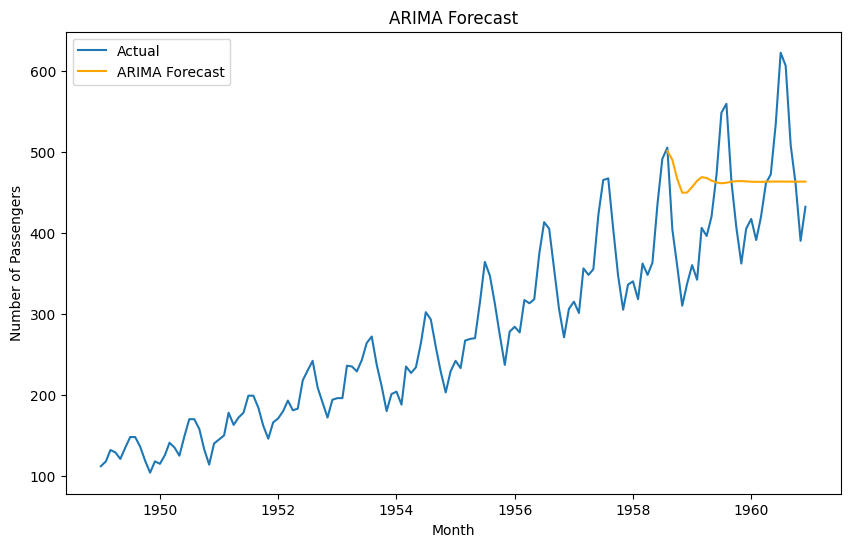

In [10]:
# ------------------ ARIMA Model ------------------
# Fit ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))  # Adjust the order as needed
arima_result = arima_model.fit()

# Forecast using ARIMA
arima_forecast = arima_result.forecast(steps=len(test))

# Plot ARIMA forecast
plt.figure(figsize=(10, 6))
plt.plot(series, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange')
plt.title('ARIMA Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1038
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0652
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0494
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0299
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0211
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0146 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0174
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0157
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0135
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0110
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0120
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0100
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0095
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0084
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0077
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms

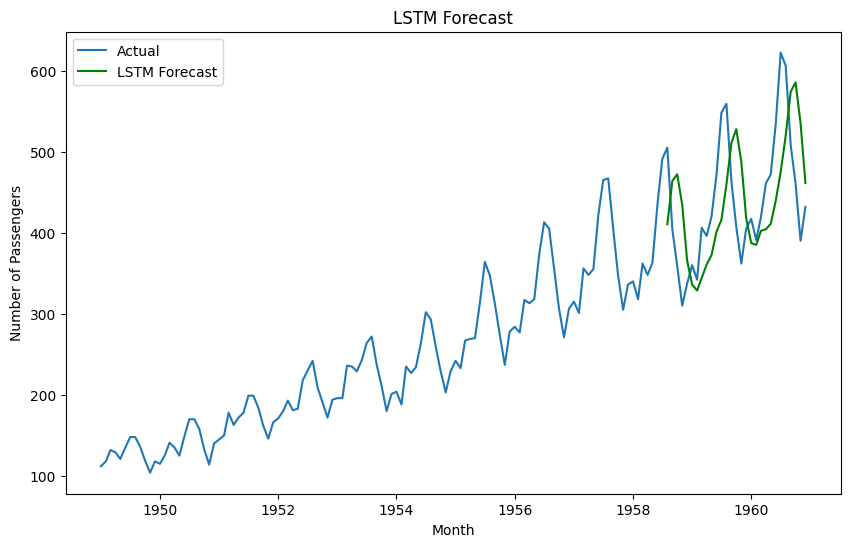

In [ ]:
# ------------------ LSTM Model ------------------
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))

# Prepare the data for LSTM
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_dataset(scaled_data, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Plot LSTM forecast
plt.figure(figsize=(10, 6))
plt.plot(series, label='Actual')
plt.plot(test.index, lstm_predictions, label='LSTM Forecast', color='green')
plt.title('LSTM Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()
